<a href="https://colab.research.google.com/github/Direspecific/CCDATRCL_PROJECT/blob/main/Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# --- Load Data ---
!git clone https://github.com/Direspecific/CCDATRCL_PROJECT.git
csv_files = glob.glob("CCDATRCL_PROJECT/*.csv")
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Filter Ranked Solo/Duo TOP games
df = df[(df['game_mode'] == 'Ranked Solo/Duo') & (df['position'] == 'TOP')]

Cloning into 'CCDATRCL_PROJECT'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
Receiving objects: 100% (108/108), 75.95 KiB | 4.22 MiB/s, done.
remote: Total 108 (delta 39), reused 0 (delta 0), pack-reused 0 (from 0)
Resolving deltas: 100% (39/39), done.


In [3]:
# --- Define metrics and convert to numeric ---
metrics = ['cs_per_minute', 'KDA', 'gold_earned', 'win']
for m in metrics:
    df[m] = pd.to_numeric(df[m], errors='coerce')

# Convert 'win' column to numeric 1/0
df['win'] = df['win'].apply(lambda x: 1 if x in [1, 'Win', True, 'win', 'WIN'] else 0)

# Convert game date
df['game_date'] = pd.to_datetime(df['game_start_date'], errors='coerce')

# Period split (Before/After research start date)
research_start = pd.Timestamp("2025-11-16")
df['period'] = np.where(df['game_date'] < research_start, 'Before', 'After')

# Drop rows with missing data
df_clean = df.dropna(subset=metrics + ['period'])

In [4]:
# --- Hypothesis Testing Function ---
def test_metric(df, metric, alpha=0.05):
    before = df[df['period'] == 'Before'][metric]
    after = df[df['period'] == 'After'][metric]

    print(f"\nMetric: {metric}")
    print(f"Before: n={len(before)}, mean={before.mean():.3f}")
    print(f"After: n={len(after)}, mean={after.mean():.3f}")

    if len(before) < 5 or len(after) < 5:
        print("❌ Not enough data for testing")
        return

    if before.var() > 0 and after.var() > 0:
        # Welch's t-test (one-tailed)
        t_stat, p_two_tailed = stats.ttest_ind(after, before, equal_var=False)
        p_value = p_two_tailed / 2
        test_used = "Welch's t-test (one-tailed)"
    else:
        # Non-parametric
        u_stat, p_value = stats.mannwhitneyu(after, before, alternative='greater')
        test_used = "Mann–Whitney U test (one-tailed)"

    print(f"Test used: {test_used}")
    print(f"p-value: {p_value:.4f}")

    if p_value < alpha:
        print("✅ Reject H₀ → Statistically significant improvement")
    else:
        print("❌ Fail to reject H₀ → No significant improvement")

# Run hypothesis tests for all metrics
for m in metrics:
    test_metric(df_clean, m)



Metric: cs_per_minute
Before: n=24, mean=5.360
After: n=168, mean=5.940
Test used: Welch's t-test (one-tailed)
p-value: 0.0719
❌ Fail to reject H₀ → No significant improvement

Metric: KDA
Before: n=24, mean=2.743
After: n=168, mean=3.205
Test used: Welch's t-test (one-tailed)
p-value: 0.1821
❌ Fail to reject H₀ → No significant improvement

Metric: gold_earned
Before: n=24, mean=10899.667
After: n=168, mean=11120.339
Test used: Welch's t-test (one-tailed)
p-value: 0.3903
❌ Fail to reject H₀ → No significant improvement

Metric: win
Before: n=24, mean=0.458
After: n=168, mean=0.494
Test used: Welch's t-test (one-tailed)
p-value: 0.3748
❌ Fail to reject H₀ → No significant improvement


In [9]:
summary = df.groupby('period')[[
    'cs_per_minute',
    'KDA',
    'gold_earned',
    'damage_dealt',
    'win'
]].mean()

summary

,cs_per_minute,KDA,gold_earned,damage_dealt,win
period,,,,,
After,5.939643,3.205000,11120.339286,22604.684524,0.494048
Before,5.359583,2.742917,10899.666667,19807.625000,0.458333


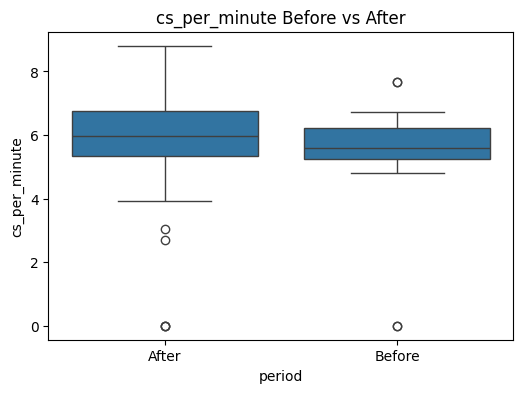

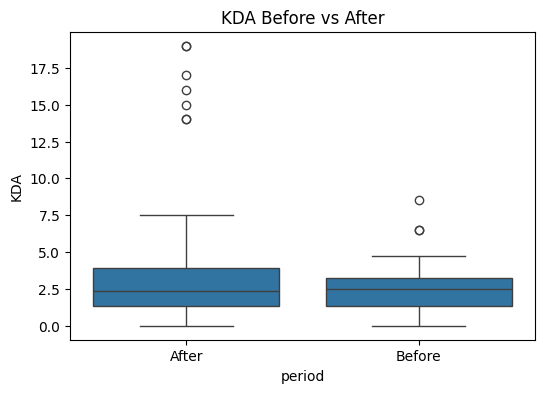

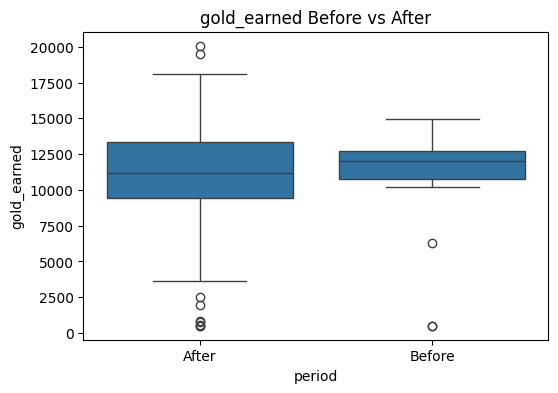

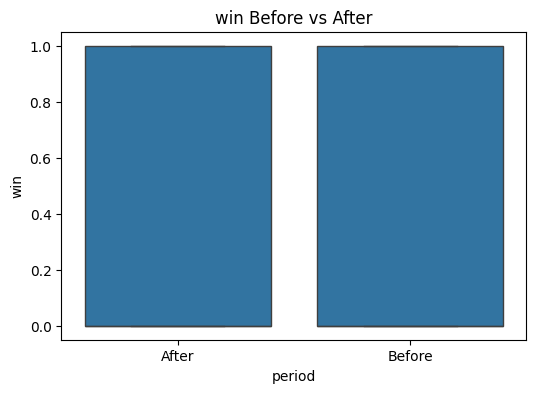

In [5]:
# --- Boxplots for Before vs After ---
for m in metrics:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_clean, x='period', y=m)
    plt.title(f'{m} Before vs After')
    plt.show()

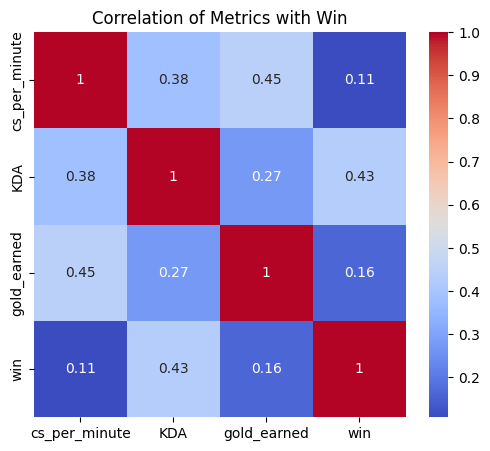

In [6]:
# --- Correlation Heatmap ---
plt.figure(figsize=(6,5))
corr = df_clean[metrics].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Metrics with Win')
plt.show()

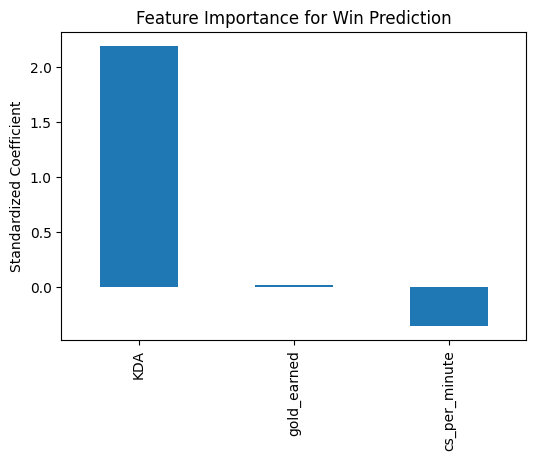

In [7]:
# --- Logistic Regression Feature Importance ---
X = df_clean[metrics[:-1]]  # features: cs_per_minute, KDA, gold_earned
y = df_clean['win']          # target: 0/1

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# Feature importance plot
importance = pd.Series(model.coef_[0], index=metrics[:-1]).sort_values(ascending=False)
plt.figure(figsize=(6,4))
importance.plot(kind='bar')
plt.title('Feature Importance for Win Prediction')
plt.ylabel('Standardized Coefficient')
plt.show()


In [8]:
# --- Model Evaluation ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7241379310344828
              precision    recall  f1-score   support

           0       0.65      0.85      0.73        26
           1       0.83      0.62      0.71        32

    accuracy                           0.72        58
   macro avg       0.74      0.74      0.72        58
weighted avg       0.75      0.72      0.72        58

